## Demand Forecasting Pipeline
<b> Day 1: Setting up basics for forecasting pipeline

In [1]:
import numpy as np
import pandas as pd
import pandasql as ps
import math
import itertools 
from scipy import stats
import time


#matplotlib libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
import seaborn as sns

#date libraries
from dateutil import parser
from datetime import datetime, timedelta, date
import holidays

#prophet library
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation, performance_metrics

#pandas options
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#matplotlib setting defaults
sns.set(font="Arial",
        rc={
 "axes.axisbelow": False,
 "axes.edgecolor": "lightgrey",
 "axes.facecolor": "None",
 "axes.grid": False,
 "axes.labelcolor": "dimgrey",
 "axes.spines.right": False,
 "axes.spines.top": False,
 "figure.facecolor": "white",
 "lines.solid_capstyle": "round",
 "patch.edgecolor": "w",
 "patch.force_edgecolor": True,
 "text.color": "dimgrey",
 "xtick.bottom": False,
 "xtick.color": "dimgrey",
 "xtick.direction": "out",
 "xtick.top": False,
 "ytick.color": "dimgrey",
 "ytick.direction": "out",
 "ytick.left": False,
 "ytick.right": False})

c:\Users\Nourhan\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [6]:
def missing_data(input_data):
    '''
    This function returns dataframe with information about the percentage of nulls in each column and the column data type.
    
    input: pandas df
    output: pandas df
    
    '''
    
    total = input_data.isnull().sum()
    percent = (input_data.isnull().sum()/input_data.isnull().count()*100)
    table = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
    types = []
    for col in input_data.columns: 
        dtype = str(input_data[col].dtype)
        types.append(dtype)
    table["Types"] = types
    return(pd.DataFrame(table))

def mape(actual, pred): 
    '''
    Mean Absolute Percentage Error (MAPE) Function
    
    input: list/series for actual values and predicted values
    output: mape value 
    '''
    actual, pred = np.array(actual), np.array(pred)
    # Filter out zero actual values to avoid division by zero
    mask = actual != 0
    actual, pred = actual[mask], pred[mask]
    return np.mean(np.abs((actual - pred) / actual)) * 100

### Reading in Data


In [7]:
df = pd.read_csv('quik_data_all.csv')
df.columns = df.columns.str.lower()
df['order_received_timestamp'] = pd.to_datetime(df['order_received_timestamp'], errors='coerce')


In [8]:
min(df['order_received_timestamp']), max(df['order_received_timestamp'])

(Timestamp('2023-12-01 00:00:00'), Timestamp('2024-02-29 23:40:00'))

In [9]:
df.head()

,merchant_id,order_received_timestamp,order_count
0,merchant_1,2023-12-01 00:00:00,1
1,merchant_1,2023-12-01 00:20:00,2
2,merchant_1,2023-12-01 00:40:00,3
3,merchant_1,2023-12-01 01:00:00,2
4,merchant_1,2023-12-01 01:20:00,3


In [10]:
agg_df = df.groupby(['order_received_timestamp', 'merchant_id']).agg({'order_count': 'sum'}).reset_index().sort_values(['merchant_id', 'order_received_timestamp']) #groups the data frame
#(where segment corresponds to merchant, timestamp to date, and target to orders


In [11]:
agg_df.head()

,order_received_timestamp,merchant_id,order_count
0,2023-12-01 00:00:00,merchant_1,1
7,2023-12-01 00:20:00,merchant_1,2
15,2023-12-01 00:40:00,merchant_1,3
24,2023-12-01 01:00:00,merchant_1,2
33,2023-12-01 01:20:00,merchant_1,3


In [12]:
agg_df.tail()

,order_received_timestamp,merchant_id,order_count
70659,2024-02-29 22:20:00,merchant_9,1
70671,2024-02-29 22:40:00,merchant_9,1
70682,2024-02-29 23:00:00,merchant_9,2
70691,2024-02-29 23:20:00,merchant_9,0
70699,2024-02-29 23:40:00,merchant_9,2


In [13]:
total_orders_df = agg_df.pivot(index='order_received_timestamp', columns='merchant_id', values='order_count')
total_orders_df.tail()

merchant_id,merchant_1,merchant_10,merchant_11,merchant_12,merchant_2,merchant_3,merchant_4,merchant_5,merchant_6,merchant_7,merchant_8,merchant_9
order_received_timestamp,,,,,,,,,,,,
2024-02-29 22:20:00,3.00,4.00,0.00,1.00,0.00,1.00,1.00,2.00,1.00,4.00,5.00,1.00
2024-02-29 22:40:00,1.00,5.00,2.00,0.00,2.00,1.00,4.00,1.00,2.00,3.00,1.00,1.00
2024-02-29 23:00:00,1.00,3.00,1.00,1.00,2.00,3.00,3.00,2.00,1.00,NaN,1.00,2.00
2024-02-29 23:20:00,1.00,2.00,0.00,NaN,4.00,1.00,2.00,0.00,NaN,NaN,3.00,0.00
2024-02-29 23:40:00,2.00,3.00,1.00,NaN,1.00,1.00,NaN,1.00,NaN,NaN,1.00,2.00


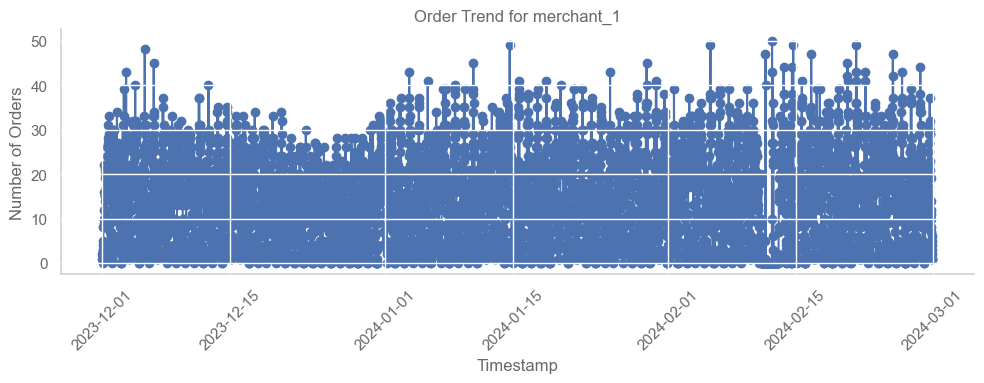

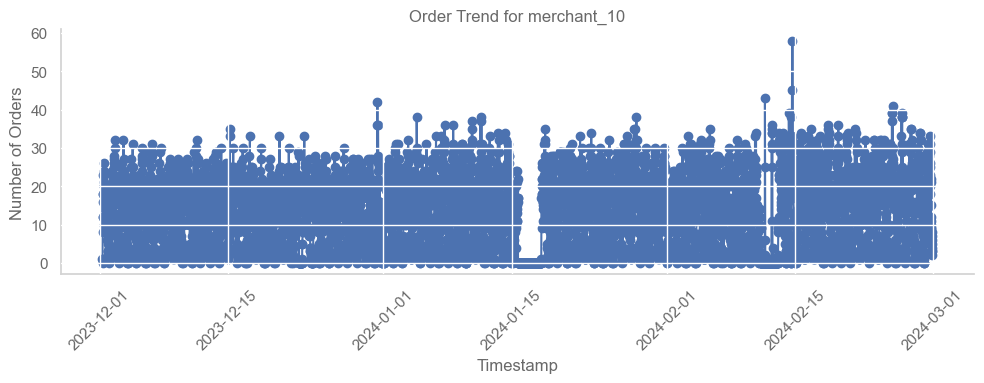

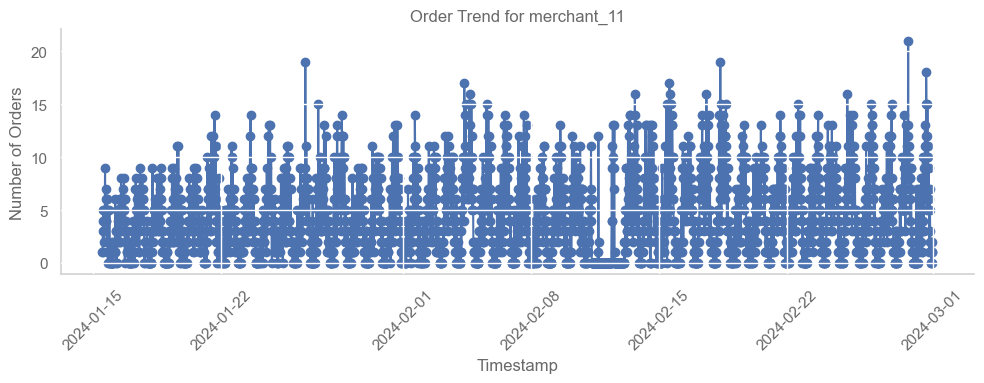

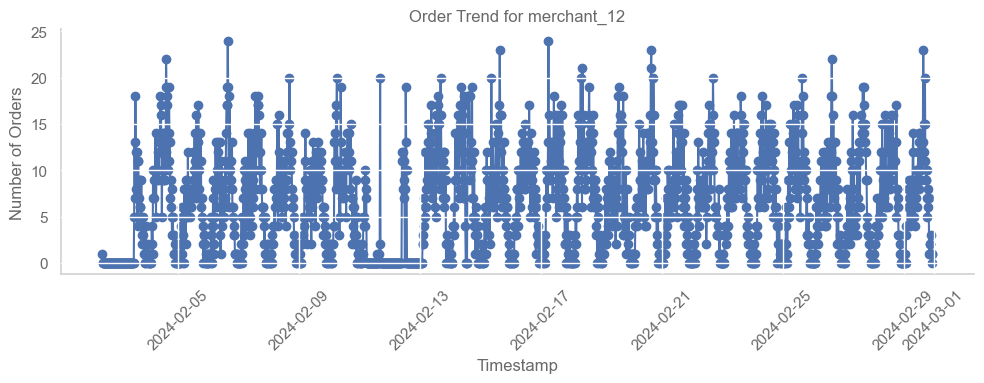

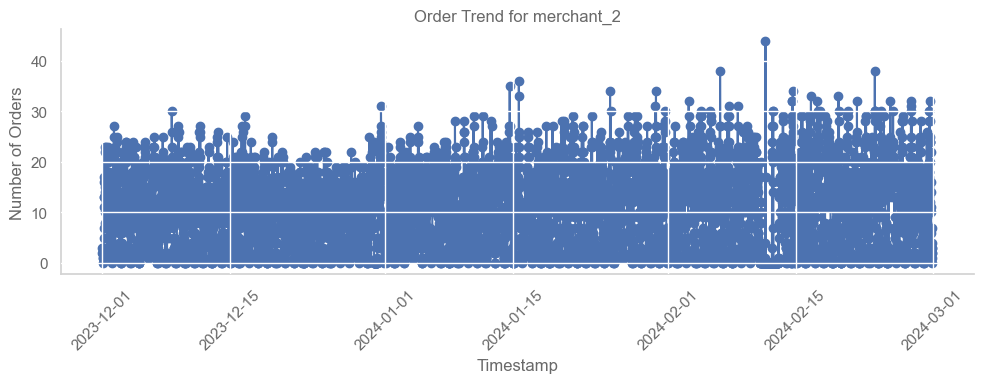

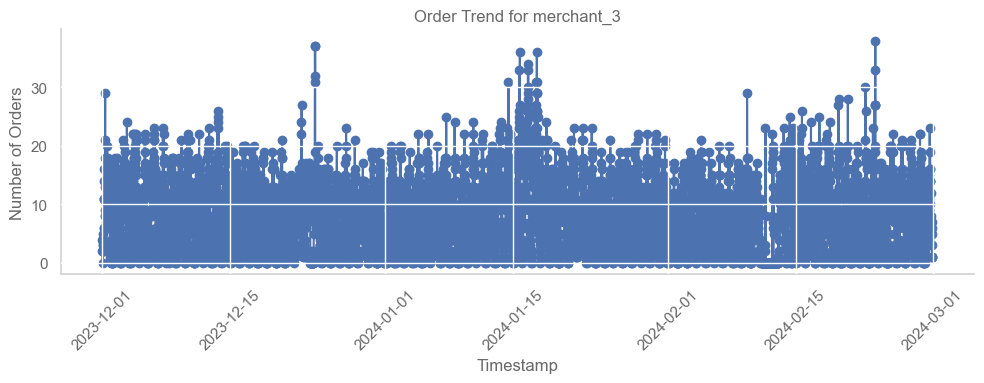

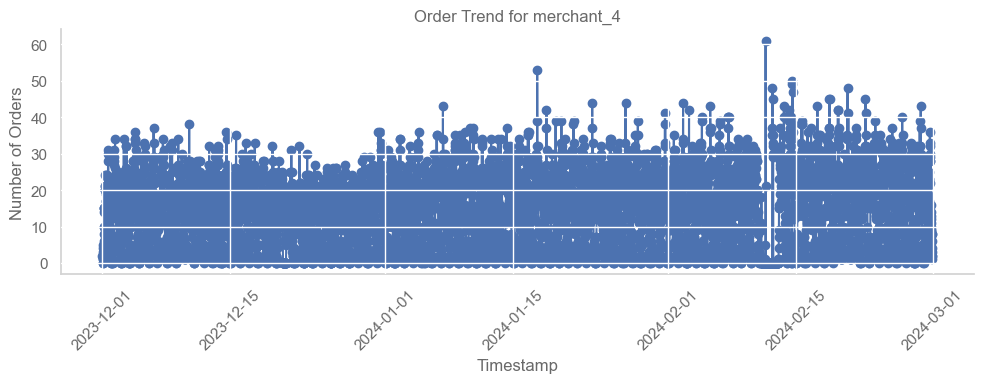

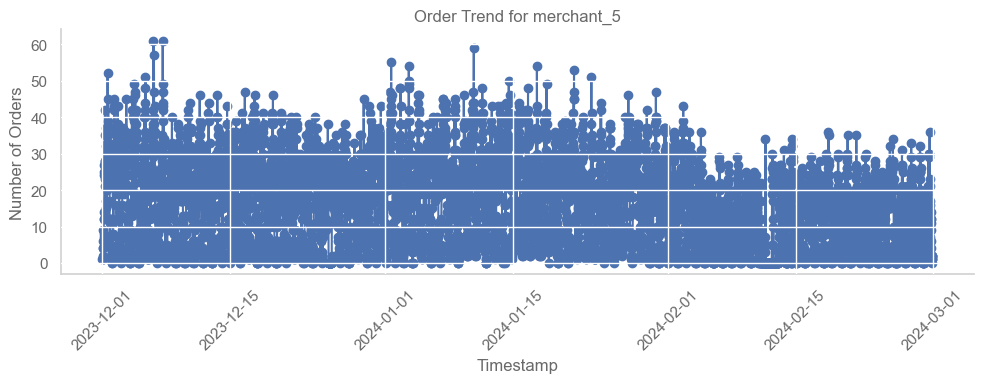

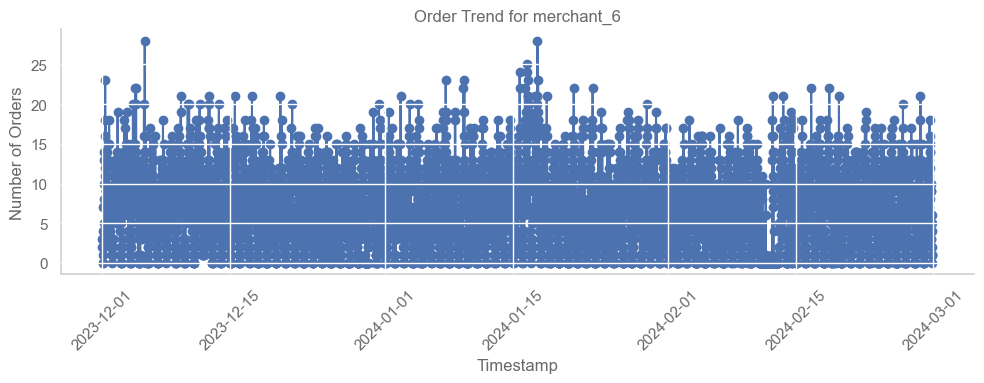

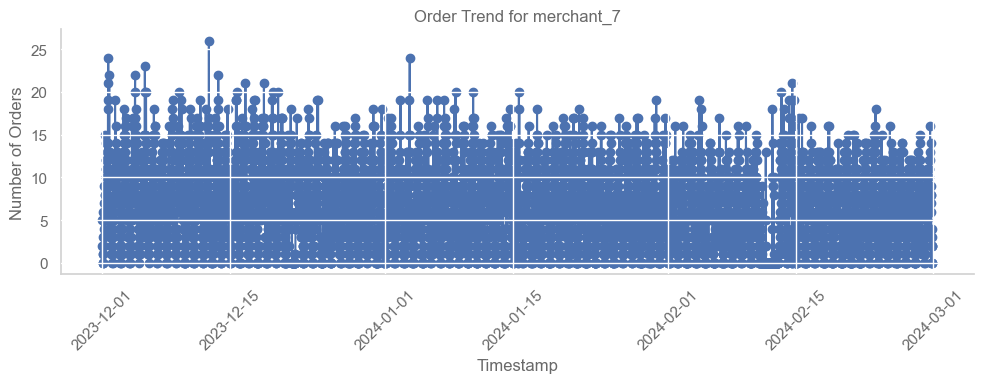

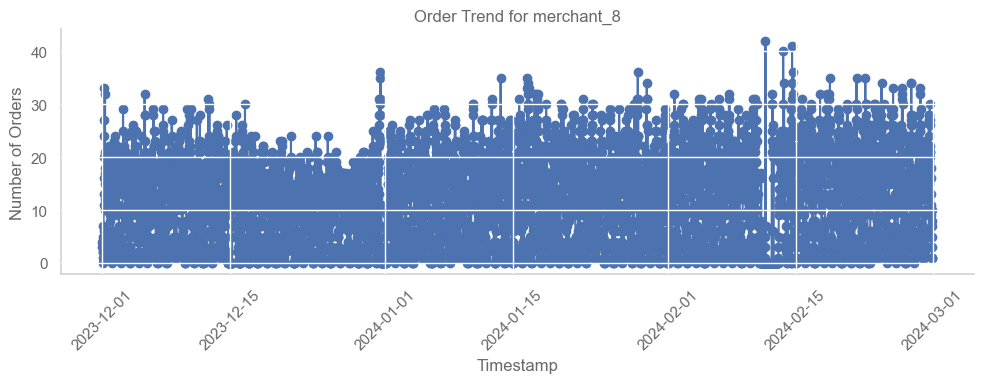

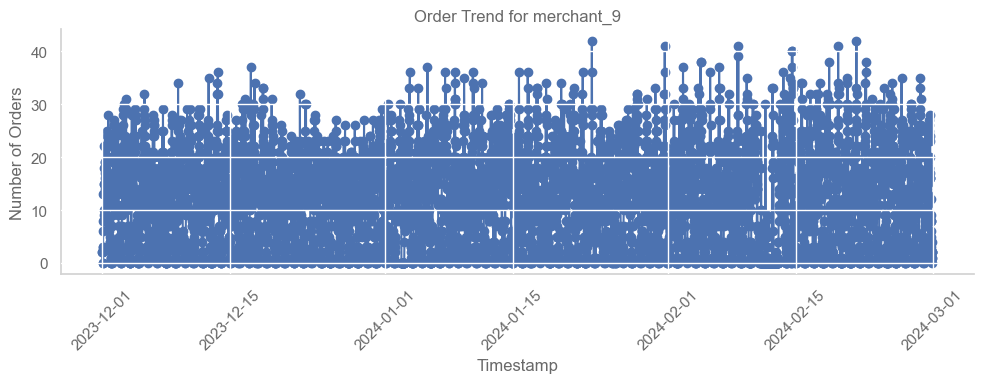

In [14]:
for column in total_orders_df.columns:
    plt.figure(figsize=(10, 4))  
    plt.plot(total_orders_df.index, total_orders_df[column], marker='o', linestyle='-')  
    plt.title(f"Order Trend for {column}")
    plt.xlabel('Timestamp')
    plt.ylabel('Number of Orders')
    plt.grid(True)  
    plt.xticks(rotation=45)  
    plt.tight_layout()  
    plt.show()

In [15]:
total_orders_df = total_orders_df[total_orders_df.index >= '2023-12-01']


In [16]:
missing_data(total_orders_df)

,Total,Percent,Types
merchant_id,,,
merchant_1,25,0.38,float64
merchant_10,23,0.35,float64
merchant_11,3285,50.14,float64
merchant_12,4573,69.80,float64
merchant_2,0,0.00,float64
merchant_3,0,0.00,float64
merchant_4,4,0.06,float64
merchant_5,0,0.00,float64
merchant_6,3,0.05,float64


In [17]:
total_orders_df.fillna(0, inplace=True) #filling nan values with zeros

# or filling NaN values with the mean of each column
#total_orders_df.fillna(total_orders_df.mean(), inplace=True)

missing_data(total_orders_df)

,Total,Percent,Types
merchant_id,,,
merchant_1,0,0.00,float64
merchant_10,0,0.00,float64
merchant_11,0,0.00,float64
merchant_12,0,0.00,float64
merchant_2,0,0.00,float64
merchant_3,0,0.00,float64
merchant_4,0,0.00,float64
merchant_5,0,0.00,float64
merchant_6,0,0.00,float64


### HYPERPARAMETER TUNING AND BACKTESTING PIPELINE

Ranges give on Prophet's documentation

1. changepoint_prior_scale [0.001, 0.5] 
2. seasonality_prior_scale [0.01, 10]
3. holidays_prior_scale [0.01, 10] 
4. seasonality_mode ['additive', 'multiplicative'].
5. changepoint_range [0.5, 0.95]

https://facebook.github.io/prophet/docs/diagnostics.html

In [22]:
changepoint_prior_scale_range = np.linspace(0.001, 0.5, num=5).tolist()
print(changepoint_prior_scale_range)

[0.001, 0.12575, 0.2505, 0.37525, 0.5]


In [23]:
seasonality_prior_scale_range = np.linspace(0.01, 10, num=5).tolist()
holidays_prior_scale_range = np.linspace(0.01, 10, num=5).tolist()

#seasonality_mode_options = ['additive', 'multiplicative']
#changepoint_range_range = list(np.linspace(0.5, 0.95, num=5))

In [27]:
start_time = time.time()

dicts = {}

for feature in total_orders_df.columns:
  
    category_df = total_orders_df[feature].copy().reset_index()
    category_df.columns = ["ds", "y"]

    category_df[["y"]] = category_df[["y"]].apply(pd.to_numeric)
    category_df["ds"] = pd.to_datetime(category_df["ds"])
    
    param_grid = {  
        "changepoint_prior_scale": changepoint_prior_scale_range,
        "seasonality_prior_scale": seasonality_prior_scale_range }
        #'holidays_prior_scale': holidays_prior_scale_range,
        #'seasonality_mode': seasonality_mode_options,
        #'changepoint_range': changepoint_range_range,

    # Generate all combinations of parameters
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    #mapes = [] 
    rmses = []
    maes = []

    # Use cross validation to evaluate all parameters
    for params in all_params:
        m = Prophet(**params).fit(category_df)  # Fit model with given params
        df_cv = cross_validation(m, initial="50 days", period="10 days", horizon = "1 days") #took parallel out
        df_p = performance_metrics(df_cv, rolling_window=1)
        print(df_p)
        #mapes.append(df_p["mape"].values[0])
        rmses.append(df_p["rmse"].values[0])
        maes.append(df_p["mae"].values[0])

    # Find the best parameters
    tuning_results = pd.DataFrame(all_params)
    #tuning_results["mape"] = mapes
    tuning_results["rmse"] = rmses
    tuning_results["mae"] = maes
    
    print(feature)
    print(tuning_results.head())

    params_dict = dict(tuning_results.sort_values("rmse").reset_index(drop=True).iloc[0])
    params_dict["column"] = feature 
    
    dicts[feature] = params_dict

print("--- %s seconds ---" % (time.time() - start_time)) #about 18 minutes

11:45:52 - cmdstanpy - INFO - Chain [1] start processing
11:45:52 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:45:52 - cmdstanpy - INFO - Chain [1] start processing
11:45:53 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:00<00:01,  1.74it/s]11:45:53 - cmdstanpy - INFO - Chain [1] start processing
11:45:53 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:01<00:01,  1.75it/s]11:45:54 - cmdstanpy - INFO - Chain [1] start processing
11:45:54 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:01<00:00,  1.83it/s]11:45:54 - cmdstanpy - INFO - Chain [1] start processing
11:45:54 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:02<00:00,  1.71it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 19.27  4.39 3.34   0.23   0.33      0.85


11:45:55 - cmdstanpy - INFO - Chain [1] start processing
11:45:55 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:45:56 - cmdstanpy - INFO - Chain [1] start processing
11:45:56 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:00<00:01,  2.10it/s]11:45:56 - cmdstanpy - INFO - Chain [1] start processing
11:45:56 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:01<00:01,  1.88it/s]11:45:57 - cmdstanpy - INFO - Chain [1] start processing
11:45:57 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:01<00:00,  1.78it/s]11:45:57 - cmdstanpy - INFO - Chain [1] start processing
11:45:58 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:02<00:00,  1.73it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 18.67  4.32 3.26   0.21   0.32      0.84


11:45:58 - cmdstanpy - INFO - Chain [1] start processing
11:45:58 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:45:59 - cmdstanpy - INFO - Chain [1] start processing
11:45:59 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:00<00:01,  1.78it/s]11:45:59 - cmdstanpy - INFO - Chain [1] start processing
11:45:59 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:01<00:01,  1.65it/s]11:46:00 - cmdstanpy - INFO - Chain [1] start processing
11:46:00 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:01<00:00,  1.65it/s]11:46:00 - cmdstanpy - INFO - Chain [1] start processing
11:46:01 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 18.76  4.33 3.27   0.21   0.32      0.84


11:46:01 - cmdstanpy - INFO - Chain [1] start processing
11:46:01 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:46:02 - cmdstanpy - INFO - Chain [1] start processing
11:46:02 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:00<00:01,  1.72it/s]11:46:02 - cmdstanpy - INFO - Chain [1] start processing
11:46:03 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:01<00:01,  1.77it/s]11:46:03 - cmdstanpy - INFO - Chain [1] start processing
11:46:03 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:01<00:00,  1.72it/s]11:46:04 - cmdstanpy - INFO - Chain [1] start processing
11:46:04 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:02<00:00,  1.68it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 18.74  4.33 3.27   0.22   0.32      0.83


11:46:04 - cmdstanpy - INFO - Chain [1] start processing
11:46:05 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:46:05 - cmdstanpy - INFO - Chain [1] start processing
11:46:05 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:00<00:01,  1.89it/s]11:46:06 - cmdstanpy - INFO - Chain [1] start processing
11:46:06 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:01<00:01,  1.72it/s]11:46:06 - cmdstanpy - INFO - Chain [1] start processing
11:46:06 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:01<00:00,  1.67it/s]11:46:07 - cmdstanpy - INFO - Chain [1] start processing
11:46:07 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 18.72  4.33 3.27   0.22   0.32      0.85


11:46:08 - cmdstanpy - INFO - Chain [1] start processing
11:46:09 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:46:10 - cmdstanpy - INFO - Chain [1] start processing
11:46:10 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:00<00:02,  1.44it/s]11:46:10 - cmdstanpy - INFO - Chain [1] start processing
11:46:11 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:01<00:01,  1.18it/s]11:46:11 - cmdstanpy - INFO - Chain [1] start processing
11:46:12 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:02<00:00,  1.06it/s]11:46:12 - cmdstanpy - INFO - Chain [1] start processing
11:46:13 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:03<00:00,  1.03it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 20.75  4.56 3.51   0.24   0.35      0.82


11:46:14 - cmdstanpy - INFO - Chain [1] start processing
11:46:14 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:46:15 - cmdstanpy - INFO - Chain [1] start processing
11:46:15 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:00<00:02,  1.28it/s]11:46:16 - cmdstanpy - INFO - Chain [1] start processing
11:46:16 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:01<00:01,  1.16it/s]11:46:17 - cmdstanpy - INFO - Chain [1] start processing
11:46:17 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:02<00:00,  1.10it/s]11:46:18 - cmdstanpy - INFO - Chain [1] start processing
11:46:19 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 20.31  4.51 3.45   0.25   0.35      0.81


11:46:19 - cmdstanpy - INFO - Chain [1] start processing
11:46:20 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:46:21 - cmdstanpy - INFO - Chain [1] start processing
11:46:21 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:00<00:02,  1.18it/s]11:46:21 - cmdstanpy - INFO - Chain [1] start processing
11:46:22 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:01<00:01,  1.16it/s]11:46:22 - cmdstanpy - INFO - Chain [1] start processing
11:46:23 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:02<00:00,  1.10it/s]11:46:23 - cmdstanpy - INFO - Chain [1] start processing
11:46:24 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 20.27  4.50 3.45   0.25   0.35      0.81


11:46:25 - cmdstanpy - INFO - Chain [1] start processing
11:46:26 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:46:26 - cmdstanpy - INFO - Chain [1] start processing
11:46:27 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:00<00:02,  1.38it/s]11:46:27 - cmdstanpy - INFO - Chain [1] start processing
11:46:28 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:01<00:01,  1.15it/s]11:46:28 - cmdstanpy - INFO - Chain [1] start processing
11:46:29 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:02<00:00,  1.12it/s]11:46:29 - cmdstanpy - INFO - Chain [1] start processing
11:46:30 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:03<00:00,  1.01it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 20.25  4.50 3.44   0.25   0.35      0.83


11:46:31 - cmdstanpy - INFO - Chain [1] start processing
11:46:32 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:46:32 - cmdstanpy - INFO - Chain [1] start processing
11:46:32 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:00<00:02,  1.16it/s]11:46:33 - cmdstanpy - INFO - Chain [1] start processing
11:46:33 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:01<00:01,  1.10it/s]11:46:34 - cmdstanpy - INFO - Chain [1] start processing
11:46:34 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:02<00:00,  1.03it/s]11:46:35 - cmdstanpy - INFO - Chain [1] start processing
11:46:36 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 20.27  4.50 3.45   0.25   0.35      0.82


11:46:37 - cmdstanpy - INFO - Chain [1] start processing
11:46:38 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:46:39 - cmdstanpy - INFO - Chain [1] start processing
11:46:39 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:00<00:02,  1.26it/s]11:46:40 - cmdstanpy - INFO - Chain [1] start processing
11:46:40 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:01<00:01,  1.18it/s]11:46:41 - cmdstanpy - INFO - Chain [1] start processing
11:46:41 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:02<00:00,  1.03it/s]11:46:42 - cmdstanpy - INFO - Chain [1] start processing
11:46:43 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 21.03  4.59 3.54   0.24   0.35      0.82


11:46:43 - cmdstanpy - INFO - Chain [1] start processing
11:46:44 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:46:45 - cmdstanpy - INFO - Chain [1] start processing
11:46:45 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:00<00:02,  1.17it/s]11:46:46 - cmdstanpy - INFO - Chain [1] start processing
11:46:46 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:01<00:01,  1.01it/s]11:46:47 - cmdstanpy - INFO - Chain [1] start processing
11:46:47 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:02<00:00,  1.03it/s]11:46:48 - cmdstanpy - INFO - Chain [1] start processing
11:46:49 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 20.53  4.53 3.48   0.25   0.35      0.82


11:46:49 - cmdstanpy - INFO - Chain [1] start processing
11:46:50 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:46:51 - cmdstanpy - INFO - Chain [1] start processing
11:46:51 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:00<00:02,  1.26it/s]11:46:51 - cmdstanpy - INFO - Chain [1] start processing
11:46:52 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:01<00:01,  1.00it/s]11:46:53 - cmdstanpy - INFO - Chain [1] start processing
11:46:53 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:02<00:00,  1.01it/s]11:46:54 - cmdstanpy - INFO - Chain [1] start processing
11:46:54 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 20.49  4.53 3.47   0.25   0.35      0.83


11:46:55 - cmdstanpy - INFO - Chain [1] start processing
11:46:56 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:46:57 - cmdstanpy - INFO - Chain [1] start processing
11:46:57 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:00<00:02,  1.01it/s]11:46:57 - cmdstanpy - INFO - Chain [1] start processing
11:46:58 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:01<00:01,  1.04it/s]11:46:58 - cmdstanpy - INFO - Chain [1] start processing
11:46:59 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:03<00:01,  1.02s/it]11:47:00 - cmdstanpy - INFO - Chain [1] start processing
11:47:01 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:04<00:00,  1.11s/it]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 20.54  4.53 3.48   0.25   0.35      0.81


11:47:01 - cmdstanpy - INFO - Chain [1] start processing
11:47:02 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:47:02 - cmdstanpy - INFO - Chain [1] start processing
11:47:03 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:00<00:02,  1.25it/s]11:47:03 - cmdstanpy - INFO - Chain [1] start processing
11:47:04 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:01<00:01,  1.08it/s]11:47:04 - cmdstanpy - INFO - Chain [1] start processing
11:47:05 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:02<00:00,  1.02it/s]11:47:05 - cmdstanpy - INFO - Chain [1] start processing
11:47:06 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:04<00:00,  1.05s/it]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 20.53  4.53 3.48   0.25   0.35      0.81


11:47:07 - cmdstanpy - INFO - Chain [1] start processing
11:47:08 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:47:08 - cmdstanpy - INFO - Chain [1] start processing
11:47:09 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:01<00:03,  1.05s/it]11:47:09 - cmdstanpy - INFO - Chain [1] start processing
11:47:10 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:02<00:02,  1.04s/it]11:47:10 - cmdstanpy - INFO - Chain [1] start processing
11:47:11 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:03<00:01,  1.16s/it]11:47:12 - cmdstanpy - INFO - Chain [1] start processing
11:47:13 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:04<00:00,  1.22s/it]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 21.15  4.60 3.55   0.25   0.36      0.82


11:47:13 - cmdstanpy - INFO - Chain [1] start processing
11:47:15 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:47:15 - cmdstanpy - INFO - Chain [1] start processing
11:47:16 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:01<00:03,  1.10s/it]11:47:16 - cmdstanpy - INFO - Chain [1] start processing
11:47:17 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:02<00:02,  1.09s/it]11:47:17 - cmdstanpy - INFO - Chain [1] start processing
11:47:18 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:03<00:01,  1.18s/it]11:47:19 - cmdstanpy - INFO - Chain [1] start processing
11:47:20 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:05<00:00,  1.40s/it]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 20.65  4.54 3.49   0.25   0.35      0.81


11:47:21 - cmdstanpy - INFO - Chain [1] start processing
11:47:23 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:47:23 - cmdstanpy - INFO - Chain [1] start processing
11:47:24 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:01<00:03,  1.05s/it]11:47:25 - cmdstanpy - INFO - Chain [1] start processing
11:47:25 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:02<00:02,  1.15s/it]11:47:26 - cmdstanpy - INFO - Chain [1] start processing
11:47:27 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:03<00:01,  1.20s/it]11:47:27 - cmdstanpy - INFO - Chain [1] start processing
11:47:28 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 20.66  4.55 3.49   0.25   0.35      0.83


11:47:29 - cmdstanpy - INFO - Chain [1] start processing
11:47:31 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:47:31 - cmdstanpy - INFO - Chain [1] start processing
11:47:32 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:01<00:03,  1.21s/it]11:47:33 - cmdstanpy - INFO - Chain [1] start processing
11:47:33 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:02<00:02,  1.22s/it]11:47:34 - cmdstanpy - INFO - Chain [1] start processing
11:47:35 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:03<00:01,  1.15s/it]11:47:35 - cmdstanpy - INFO - Chain [1] start processing
11:47:36 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 20.64  4.54 3.49   0.25   0.35      0.82


11:47:37 - cmdstanpy - INFO - Chain [1] start processing
11:47:39 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:47:39 - cmdstanpy - INFO - Chain [1] start processing
11:47:40 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:01<00:04,  1.37s/it]11:47:40 - cmdstanpy - INFO - Chain [1] start processing
11:47:41 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:02<00:02,  1.32s/it]11:47:42 - cmdstanpy - INFO - Chain [1] start processing
11:47:43 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:04<00:01,  1.39s/it]11:47:44 - cmdstanpy - INFO - Chain [1] start processing
11:47:46 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 20.66  4.54 3.49   0.25   0.35      0.82


11:47:46 - cmdstanpy - INFO - Chain [1] start processing
11:47:48 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:47:48 - cmdstanpy - INFO - Chain [1] start processing
11:47:49 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:01<00:03,  1.12s/it]11:47:49 - cmdstanpy - INFO - Chain [1] start processing
11:47:51 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:02<00:02,  1.46s/it]11:47:51 - cmdstanpy - INFO - Chain [1] start processing
11:47:52 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:04<00:01,  1.60s/it]11:47:53 - cmdstanpy - INFO - Chain [1] start processing
11:47:54 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:06<00:00,  1.61s/it]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 21.24  4.61 3.56   0.25   0.36      0.82


11:47:55 - cmdstanpy - INFO - Chain [1] start processing
11:47:56 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:47:57 - cmdstanpy - INFO - Chain [1] start processing
11:47:57 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:01<00:03,  1.23s/it]11:47:58 - cmdstanpy - INFO - Chain [1] start processing
11:47:58 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:02<00:02,  1.09s/it]11:47:59 - cmdstanpy - INFO - Chain [1] start processing
11:48:00 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:03<00:01,  1.24s/it]11:48:00 - cmdstanpy - INFO - Chain [1] start processing
11:48:02 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:06<00:00,  1.52s/it]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 20.75  4.56 3.50   0.25   0.35      0.81


11:48:03 - cmdstanpy - INFO - Chain [1] start processing
11:48:04 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:48:04 - cmdstanpy - INFO - Chain [1] start processing
11:48:05 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:01<00:03,  1.14s/it]11:48:05 - cmdstanpy - INFO - Chain [1] start processing
11:48:07 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:02<00:02,  1.40s/it]11:48:07 - cmdstanpy - INFO - Chain [1] start processing
11:48:08 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:04<00:01,  1.63s/it]11:48:09 - cmdstanpy - INFO - Chain [1] start processing
11:48:11 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:06<00:00,  1.72s/it]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 20.79  4.56 3.51   0.25   0.35      0.83


11:48:11 - cmdstanpy - INFO - Chain [1] start processing
11:48:12 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:48:13 - cmdstanpy - INFO - Chain [1] start processing
11:48:14 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:01<00:03,  1.17s/it]11:48:14 - cmdstanpy - INFO - Chain [1] start processing
11:48:15 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:02<00:02,  1.41s/it]11:48:16 - cmdstanpy - INFO - Chain [1] start processing
11:48:17 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:04<00:01,  1.52s/it]11:48:17 - cmdstanpy - INFO - Chain [1] start processing
11:48:19 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:06<00:00,  1.72s/it]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 20.76  4.56 3.50   0.25   0.35      0.81


11:48:20 - cmdstanpy - INFO - Chain [1] start processing
11:48:22 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:48:22 - cmdstanpy - INFO - Chain [1] start processing
11:48:23 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:01<00:03,  1.21s/it]11:48:24 - cmdstanpy - INFO - Chain [1] start processing
11:48:24 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:02<00:02,  1.21s/it]11:48:25 - cmdstanpy - INFO - Chain [1] start processing
11:48:26 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:03<00:01,  1.22s/it]11:48:26 - cmdstanpy - INFO - Chain [1] start processing
11:48:28 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:05<00:00,  1.49s/it]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 20.76  4.56 3.50   0.25   0.35      0.82
merchant_1
   changepoint_prior_scale  seasonality_prior_scale  rmse  mae
0                     0.00                     0.01  4.39 3.34
1                     0.00                     2.51  4.32 3.26
2                     0.00                     5.00  4.33 3.27
3                     0.00                     7.50  4.33 3.27
4                     0.00                    10.00  4.33 3.27


11:48:29 - cmdstanpy - INFO - Chain [1] start processing
11:48:29 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:48:29 - cmdstanpy - INFO - Chain [1] start processing
11:48:29 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:00<00:01,  1.85it/s]11:48:30 - cmdstanpy - INFO - Chain [1] start processing
11:48:30 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:01<00:01,  1.73it/s]11:48:30 - cmdstanpy - INFO - Chain [1] start processing
11:48:31 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:01<00:00,  1.73it/s]11:48:31 - cmdstanpy - INFO - Chain [1] start processing
11:48:31 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:02<00:00,  1.55it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 19.79  4.45 3.31   0.23   0.34      0.86


11:48:32 - cmdstanpy - INFO - Chain [1] start processing
11:48:32 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:48:33 - cmdstanpy - INFO - Chain [1] start processing
11:48:33 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:00<00:01,  2.09it/s]11:48:33 - cmdstanpy - INFO - Chain [1] start processing
11:48:33 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:01<00:01,  1.87it/s]11:48:34 - cmdstanpy - INFO - Chain [1] start processing
11:48:34 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:01<00:00,  1.62it/s]11:48:35 - cmdstanpy - INFO - Chain [1] start processing
11:48:35 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:02<00:00,  1.64it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 19.48  4.41 3.27   0.23   0.34      0.87


11:48:35 - cmdstanpy - INFO - Chain [1] start processing
11:48:36 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:48:36 - cmdstanpy - INFO - Chain [1] start processing
11:48:36 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:00<00:01,  2.16it/s]11:48:36 - cmdstanpy - INFO - Chain [1] start processing
11:48:37 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:01<00:01,  1.85it/s]11:48:37 - cmdstanpy - INFO - Chain [1] start processing
11:48:37 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:01<00:00,  1.62it/s]11:48:38 - cmdstanpy - INFO - Chain [1] start processing
11:48:38 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:02<00:00,  1.67it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 19.26  4.39 3.25   0.22   0.33      0.87


11:48:39 - cmdstanpy - INFO - Chain [1] start processing
11:48:39 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:48:39 - cmdstanpy - INFO - Chain [1] start processing
11:48:39 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:00<00:01,  2.10it/s]11:48:40 - cmdstanpy - INFO - Chain [1] start processing
11:48:40 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:01<00:01,  1.61it/s]11:48:40 - cmdstanpy - INFO - Chain [1] start processing
11:48:41 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:01<00:00,  1.62it/s]11:48:41 - cmdstanpy - INFO - Chain [1] start processing
11:48:41 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 19.44  4.41 3.26   0.22   0.33      0.86


11:48:42 - cmdstanpy - INFO - Chain [1] start processing
11:48:42 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:48:43 - cmdstanpy - INFO - Chain [1] start processing
11:48:43 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:00<00:01,  2.07it/s]11:48:43 - cmdstanpy - INFO - Chain [1] start processing
11:48:43 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:00<00:00,  2.03it/s]11:48:44 - cmdstanpy - INFO - Chain [1] start processing
11:48:44 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:01<00:00,  1.68it/s]11:48:44 - cmdstanpy - INFO - Chain [1] start processing
11:48:45 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:02<00:00,  1.69it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 19.53  4.42 3.27   0.23   0.34      0.87


11:48:45 - cmdstanpy - INFO - Chain [1] start processing
11:48:47 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:48:48 - cmdstanpy - INFO - Chain [1] start processing
11:48:48 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:00<00:02,  1.22it/s]11:48:49 - cmdstanpy - INFO - Chain [1] start processing
11:48:50 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:02<00:02,  1.41s/it]11:48:51 - cmdstanpy - INFO - Chain [1] start processing
11:48:52 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:04<00:01,  1.59s/it]11:48:52 - cmdstanpy - INFO - Chain [1] start processing
11:48:54 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:06<00:00,  1.55s/it]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 20.33  4.51 3.50   0.21   0.36      0.85


11:48:54 - cmdstanpy - INFO - Chain [1] start processing
11:48:56 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:48:56 - cmdstanpy - INFO - Chain [1] start processing
11:48:57 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:00<00:02,  1.07it/s]11:48:57 - cmdstanpy - INFO - Chain [1] start processing
11:48:58 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:02<00:02,  1.37s/it]11:48:59 - cmdstanpy - INFO - Chain [1] start processing
11:49:00 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:04<00:01,  1.74s/it]11:49:01 - cmdstanpy - INFO - Chain [1] start processing
11:49:02 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:06<00:00,  1.72s/it]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 19.89  4.46 3.42   0.21   0.35      0.85


11:49:03 - cmdstanpy - INFO - Chain [1] start processing
11:49:05 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:49:05 - cmdstanpy - INFO - Chain [1] start processing
11:49:06 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:00<00:02,  1.20it/s]11:49:06 - cmdstanpy - INFO - Chain [1] start processing
11:49:07 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:02<00:02,  1.10s/it]11:49:08 - cmdstanpy - INFO - Chain [1] start processing
11:49:09 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:03<00:01,  1.36s/it]11:49:09 - cmdstanpy - INFO - Chain [1] start processing
11:49:11 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:05<00:00,  1.44s/it]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 19.84  4.45 3.42   0.21   0.35      0.84


11:49:11 - cmdstanpy - INFO - Chain [1] start processing
11:49:12 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:49:13 - cmdstanpy - INFO - Chain [1] start processing
11:49:13 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:00<00:02,  1.07it/s]11:49:14 - cmdstanpy - INFO - Chain [1] start processing
11:49:15 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:02<00:02,  1.24s/it]11:49:16 - cmdstanpy - INFO - Chain [1] start processing
11:49:17 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:04<00:01,  1.83s/it]11:49:18 - cmdstanpy - INFO - Chain [1] start processing
11:49:19 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:06<00:00,  1.73s/it]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 19.78  4.45 3.42   0.21   0.35      0.84


11:49:20 - cmdstanpy - INFO - Chain [1] start processing
11:49:22 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:49:22 - cmdstanpy - INFO - Chain [1] start processing
11:49:22 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:00<00:02,  1.17it/s]11:49:23 - cmdstanpy - INFO - Chain [1] start processing
11:49:24 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:02<00:02,  1.37s/it]11:49:25 - cmdstanpy - INFO - Chain [1] start processing
11:49:26 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:04<00:01,  1.61s/it]11:49:27 - cmdstanpy - INFO - Chain [1] start processing
11:49:28 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:06<00:00,  1.68s/it]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 19.94  4.46 3.43   0.21   0.35      0.86


11:49:29 - cmdstanpy - INFO - Chain [1] start processing
11:49:31 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:49:31 - cmdstanpy - INFO - Chain [1] start processing
11:49:33 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:01<00:05,  1.85s/it]11:49:34 - cmdstanpy - INFO - Chain [1] start processing
11:49:35 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:04<00:04,  2.08s/it]11:49:36 - cmdstanpy - INFO - Chain [1] start processing
11:49:38 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:06<00:02,  2.20s/it]11:49:38 - cmdstanpy - INFO - Chain [1] start processing
11:49:40 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:08<00:00,  2.21s/it]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 20.12  4.49 3.47   0.21   0.35      0.83


11:49:40 - cmdstanpy - INFO - Chain [1] start processing
11:49:44 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:49:44 - cmdstanpy - INFO - Chain [1] start processing
11:49:46 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:02<00:06,  2.32s/it]11:49:47 - cmdstanpy - INFO - Chain [1] start processing
11:49:48 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:04<00:04,  2.25s/it]11:49:49 - cmdstanpy - INFO - Chain [1] start processing
11:49:51 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:06<00:02,  2.16s/it]11:49:51 - cmdstanpy - INFO - Chain [1] start processing
11:49:53 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:08<00:00,  2.19s/it]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 19.74  4.44 3.41   0.21   0.35      0.82


11:49:53 - cmdstanpy - INFO - Chain [1] start processing
11:49:56 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:49:56 - cmdstanpy - INFO - Chain [1] start processing
11:49:57 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:01<00:04,  1.38s/it]11:49:57 - cmdstanpy - INFO - Chain [1] start processing
11:49:59 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:03<00:04,  2.01s/it]11:50:00 - cmdstanpy - INFO - Chain [1] start processing
11:50:02 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:06<00:02,  2.19s/it]11:50:02 - cmdstanpy - INFO - Chain [1] start processing
11:50:04 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:08<00:00,  2.21s/it]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 19.72  4.44 3.41   0.21   0.35      0.82


11:50:05 - cmdstanpy - INFO - Chain [1] start processing
11:50:07 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:50:08 - cmdstanpy - INFO - Chain [1] start processing
11:50:09 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:01<00:04,  1.52s/it]11:50:09 - cmdstanpy - INFO - Chain [1] start processing
11:50:12 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:04<00:04,  2.40s/it]11:50:12 - cmdstanpy - INFO - Chain [1] start processing
11:50:14 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:06<00:02,  2.33s/it]11:50:14 - cmdstanpy - INFO - Chain [1] start processing
11:50:17 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:09<00:00,  2.36s/it]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 19.79  4.45 3.42   0.21   0.35      0.82


11:50:17 - cmdstanpy - INFO - Chain [1] start processing
11:50:20 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:50:20 - cmdstanpy - INFO - Chain [1] start processing
11:50:21 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:01<00:03,  1.30s/it]11:50:21 - cmdstanpy - INFO - Chain [1] start processing
11:50:23 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:03<00:03,  1.73s/it]11:50:24 - cmdstanpy - INFO - Chain [1] start processing
11:50:25 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:05<00:01,  1.93s/it]11:50:26 - cmdstanpy - INFO - Chain [1] start processing
11:50:27 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:07<00:00,  1.90s/it]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 19.63  4.43 3.40   0.21   0.34      0.82


11:50:28 - cmdstanpy - INFO - Chain [1] start processing
11:50:31 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:50:31 - cmdstanpy - INFO - Chain [1] start processing
11:50:32 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:01<00:05,  1.78s/it]11:50:33 - cmdstanpy - INFO - Chain [1] start processing
11:50:36 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:05<00:05,  2.71s/it]11:50:36 - cmdstanpy - INFO - Chain [1] start processing
11:50:38 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:07<00:02,  2.69s/it]11:50:39 - cmdstanpy - INFO - Chain [1] start processing
11:50:42 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:11<00:00,  2.78s/it]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 19.91  4.46 3.46   0.21   0.35      0.83


11:50:42 - cmdstanpy - INFO - Chain [1] start processing
11:50:45 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:50:46 - cmdstanpy - INFO - Chain [1] start processing
11:50:47 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:02<00:06,  2.06s/it]11:50:48 - cmdstanpy - INFO - Chain [1] start processing
11:50:50 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:04<00:04,  2.29s/it]11:50:50 - cmdstanpy - INFO - Chain [1] start processing
11:50:53 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:07<00:02,  2.75s/it]11:50:54 - cmdstanpy - INFO - Chain [1] start processing
11:50:56 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:11<00:00,  2.77s/it]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 19.49  4.42 3.39   0.21   0.34      0.82


11:50:57 - cmdstanpy - INFO - Chain [1] start processing
11:50:59 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:51:00 - cmdstanpy - INFO - Chain [1] start processing
11:51:01 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:01<00:05,  1.87s/it]11:51:02 - cmdstanpy - INFO - Chain [1] start processing
11:51:04 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:04<00:04,  2.50s/it]11:51:05 - cmdstanpy - INFO - Chain [1] start processing
11:51:07 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:07<00:02,  2.44s/it]11:51:07 - cmdstanpy - INFO - Chain [1] start processing
11:51:09 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:09<00:00,  2.43s/it]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 19.48  4.41 3.39   0.21   0.34      0.83


11:51:10 - cmdstanpy - INFO - Chain [1] start processing
11:51:12 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:51:12 - cmdstanpy - INFO - Chain [1] start processing
11:51:14 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:01<00:05,  1.93s/it]11:51:14 - cmdstanpy - INFO - Chain [1] start processing
11:51:17 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:04<00:05,  2.52s/it]11:51:17 - cmdstanpy - INFO - Chain [1] start processing
11:51:20 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:07<00:02,  2.63s/it]11:51:20 - cmdstanpy - INFO - Chain [1] start processing
11:51:22 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:09<00:00,  2.48s/it]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 19.53  4.42 3.40   0.21   0.34      0.82


11:51:22 - cmdstanpy - INFO - Chain [1] start processing
11:51:25 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:51:25 - cmdstanpy - INFO - Chain [1] start processing
11:51:27 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:01<00:05,  1.92s/it]11:51:28 - cmdstanpy - INFO - Chain [1] start processing
11:51:30 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:04<00:04,  2.38s/it]11:51:30 - cmdstanpy - INFO - Chain [1] start processing
11:51:32 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:07<00:02,  2.49s/it]11:51:33 - cmdstanpy - INFO - Chain [1] start processing
11:51:36 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:10<00:00,  2.63s/it]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 19.47  4.41 3.39   0.21   0.34      0.83


11:51:36 - cmdstanpy - INFO - Chain [1] start processing
11:51:40 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:51:40 - cmdstanpy - INFO - Chain [1] start processing
11:51:42 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:02<00:06,  2.31s/it]11:51:42 - cmdstanpy - INFO - Chain [1] start processing
11:51:44 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:04<00:04,  2.33s/it]11:51:45 - cmdstanpy - INFO - Chain [1] start processing
11:51:47 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:07<00:02,  2.45s/it]11:51:47 - cmdstanpy - INFO - Chain [1] start processing
11:51:49 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:09<00:00,  2.40s/it]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 19.87  4.46 3.46   0.21   0.35      0.83


11:51:50 - cmdstanpy - INFO - Chain [1] start processing
11:51:53 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:51:53 - cmdstanpy - INFO - Chain [1] start processing
11:51:56 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:02<00:08,  2.91s/it]11:51:56 - cmdstanpy - INFO - Chain [1] start processing
11:52:00 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:06<00:07,  3.50s/it]11:52:00 - cmdstanpy - INFO - Chain [1] start processing
11:52:03 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:10<00:03,  3.56s/it]11:52:04 - cmdstanpy - INFO - Chain [1] start processing
11:52:08 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:14<00:00,  3.68s/it]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 19.36  4.40 3.39   0.21   0.34      0.83


11:52:08 - cmdstanpy - INFO - Chain [1] start processing
11:52:13 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:52:14 - cmdstanpy - INFO - Chain [1] start processing
11:52:15 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:01<00:05,  1.73s/it]11:52:16 - cmdstanpy - INFO - Chain [1] start processing
11:52:18 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:04<00:05,  2.55s/it]11:52:19 - cmdstanpy - INFO - Chain [1] start processing
11:52:21 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:07<00:02,  2.52s/it]11:52:21 - cmdstanpy - INFO - Chain [1] start processing
11:52:24 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 19.35  4.40 3.39   0.21   0.34      0.82


11:52:24 - cmdstanpy - INFO - Chain [1] start processing
11:52:26 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:52:27 - cmdstanpy - INFO - Chain [1] start processing
11:52:28 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:01<00:05,  1.95s/it]11:52:29 - cmdstanpy - INFO - Chain [1] start processing
11:52:30 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:04<00:04,  2.02s/it]11:52:31 - cmdstanpy - INFO - Chain [1] start processing
11:52:34 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:07<00:02,  2.75s/it]11:52:35 - cmdstanpy - INFO - Chain [1] start processing
11:52:38 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:11<00:00,  2.97s/it]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 19.36  4.40 3.39   0.21   0.34      0.82


11:52:39 - cmdstanpy - INFO - Chain [1] start processing
11:52:42 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:52:43 - cmdstanpy - INFO - Chain [1] start processing
11:52:45 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:02<00:08,  2.83s/it]11:52:46 - cmdstanpy - INFO - Chain [1] start processing
11:52:49 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:06<00:07,  3.51s/it]11:52:50 - cmdstanpy - INFO - Chain [1] start processing
11:52:52 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:10<00:03,  3.38s/it]11:52:53 - cmdstanpy - INFO - Chain [1] start processing
11:52:56 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:13<00:00,  3.33s/it]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 19.38  4.40 3.39   0.21   0.34      0.82
merchant_10
   changepoint_prior_scale  seasonality_prior_scale  rmse  mae
0                     0.00                     0.01  4.45 3.31
1                     0.00                     2.51  4.41 3.27
2                     0.00                     5.00  4.39 3.25
3                     0.00                     7.50  4.41 3.26
4                     0.00                    10.00  4.42 3.27


11:52:56 - cmdstanpy - INFO - Chain [1] start processing
11:52:56 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:52:57 - cmdstanpy - INFO - Chain [1] start processing
11:52:57 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:00<00:01,  1.82it/s]11:52:57 - cmdstanpy - INFO - Chain [1] start processing
11:52:58 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:01<00:01,  1.65it/s]11:52:58 - cmdstanpy - INFO - Chain [1] start processing
11:52:58 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:01<00:00,  1.59it/s]11:52:59 - cmdstanpy - INFO - Chain [1] start processing
11:52:59 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:02<00:00,  1.58it/s]


  horizon  mse  rmse  mae  mdape  smape  coverage
0  1 days 8.87  2.98 2.50   0.49   0.76      0.50


11:52:59 - cmdstanpy - INFO - Chain [1] start processing
11:53:00 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:53:00 - cmdstanpy - INFO - Chain [1] start processing
11:53:00 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:00<00:01,  2.02it/s]11:53:01 - cmdstanpy - INFO - Chain [1] start processing
11:53:01 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:01<00:01,  1.66it/s]11:53:01 - cmdstanpy - INFO - Chain [1] start processing
11:53:02 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:01<00:00,  1.45it/s]11:53:02 - cmdstanpy - INFO - Chain [1] start processing
11:53:03 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:02<00:00,  1.39it/s]


  horizon  mse  rmse  mae  mdape  smape  coverage
0  1 days 8.74  2.96 2.48   0.49   0.76      0.51


11:53:03 - cmdstanpy - INFO - Chain [1] start processing
11:53:03 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:53:04 - cmdstanpy - INFO - Chain [1] start processing
11:53:04 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:00<00:01,  2.15it/s]11:53:04 - cmdstanpy - INFO - Chain [1] start processing
11:53:04 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:01<00:01,  1.81it/s]11:53:05 - cmdstanpy - INFO - Chain [1] start processing
11:53:05 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:01<00:00,  1.67it/s]11:53:05 - cmdstanpy - INFO - Chain [1] start processing
11:53:06 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:02<00:00,  1.67it/s]


  horizon  mse  rmse  mae  mdape  smape  coverage
0  1 days 8.75  2.96 2.48   0.49   0.76      0.49


11:53:06 - cmdstanpy - INFO - Chain [1] start processing
11:53:06 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:53:07 - cmdstanpy - INFO - Chain [1] start processing
11:53:07 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:00<00:01,  1.63it/s]11:53:07 - cmdstanpy - INFO - Chain [1] start processing
11:53:08 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:01<00:01,  1.45it/s]11:53:08 - cmdstanpy - INFO - Chain [1] start processing
11:53:08 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:02<00:00,  1.48it/s]11:53:09 - cmdstanpy - INFO - Chain [1] start processing
11:53:09 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:02<00:00,  1.35it/s]


  horizon  mse  rmse  mae  mdape  smape  coverage
0  1 days 8.75  2.96 2.48   0.49   0.76      0.50


11:53:10 - cmdstanpy - INFO - Chain [1] start processing
11:53:10 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:53:11 - cmdstanpy - INFO - Chain [1] start processing
11:53:11 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:00<00:01,  1.93it/s]11:53:11 - cmdstanpy - INFO - Chain [1] start processing
11:53:11 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:01<00:01,  1.64it/s]11:53:12 - cmdstanpy - INFO - Chain [1] start processing
11:53:12 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:01<00:00,  1.60it/s]11:53:13 - cmdstanpy - INFO - Chain [1] start processing
11:53:13 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


  horizon  mse  rmse  mae  mdape  smape  coverage
0  1 days 8.75  2.96 2.48   0.49   0.76      0.50


11:53:13 - cmdstanpy - INFO - Chain [1] start processing
11:53:14 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:53:15 - cmdstanpy - INFO - Chain [1] start processing
11:53:15 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:00<00:02,  1.09it/s]11:53:15 - cmdstanpy - INFO - Chain [1] start processing
11:53:16 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:01<00:01,  1.09it/s]11:53:17 - cmdstanpy - INFO - Chain [1] start processing
11:53:17 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:03<00:01,  1.13s/it]11:53:18 - cmdstanpy - INFO - Chain [1] start processing
11:53:19 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


  horizon  mse  rmse  mae  mdape  smape  coverage
0  1 days 8.88  2.98 2.49   0.50   0.76      0.47


11:53:19 - cmdstanpy - INFO - Chain [1] start processing
11:53:21 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:53:21 - cmdstanpy - INFO - Chain [1] start processing
11:53:23 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:02<00:06,  2.32s/it]11:53:23 - cmdstanpy - INFO - Chain [1] start processing
11:53:24 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:03<00:03,  1.80s/it]11:53:25 - cmdstanpy - INFO - Chain [1] start processing
11:53:26 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:04<00:01,  1.50s/it]11:53:26 - cmdstanpy - INFO - Chain [1] start processing
11:53:28 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


  horizon  mse  rmse  mae  mdape  smape  coverage
0  1 days 8.78  2.96 2.48   0.49   0.75      0.47


11:53:28 - cmdstanpy - INFO - Chain [1] start processing
11:53:29 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:53:30 - cmdstanpy - INFO - Chain [1] start processing
11:53:31 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:01<00:04,  1.39s/it]11:53:31 - cmdstanpy - INFO - Chain [1] start processing
11:53:32 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:02<00:02,  1.39s/it]11:53:33 - cmdstanpy - INFO - Chain [1] start processing
11:53:33 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:04<00:01,  1.35s/it]11:53:34 - cmdstanpy - INFO - Chain [1] start processing
11:53:35 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:05<00:00,  1.48s/it]


  horizon  mse  rmse  mae  mdape  smape  coverage
0  1 days 8.76  2.96 2.47   0.50   0.75      0.49


11:53:36 - cmdstanpy - INFO - Chain [1] start processing
11:53:37 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:53:38 - cmdstanpy - INFO - Chain [1] start processing
11:53:39 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:01<00:03,  1.10s/it]11:53:39 - cmdstanpy - INFO - Chain [1] start processing
11:53:40 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:02<00:02,  1.24s/it]11:53:40 - cmdstanpy - INFO - Chain [1] start processing
11:53:42 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:04<00:01,  1.44s/it]11:53:42 - cmdstanpy - INFO - Chain [1] start processing
11:53:43 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:05<00:00,  1.49s/it]


  horizon  mse  rmse  mae  mdape  smape  coverage
0  1 days 8.77  2.96 2.47   0.50   0.75      0.48


11:53:44 - cmdstanpy - INFO - Chain [1] start processing
11:53:45 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:53:45 - cmdstanpy - INFO - Chain [1] start processing
11:53:46 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:01<00:04,  1.48s/it]11:53:47 - cmdstanpy - INFO - Chain [1] start processing
11:53:48 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:02<00:02,  1.44s/it]11:53:48 - cmdstanpy - INFO - Chain [1] start processing
11:53:49 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:03<00:01,  1.29s/it]11:53:49 - cmdstanpy - INFO - Chain [1] start processing
11:53:51 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:06<00:00,  1.53s/it]


  horizon  mse  rmse  mae  mdape  smape  coverage
0  1 days 8.78  2.96 2.48   0.50   0.75      0.47


11:53:52 - cmdstanpy - INFO - Chain [1] start processing
11:53:53 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:53:54 - cmdstanpy - INFO - Chain [1] start processing
11:53:55 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:01<00:04,  1.39s/it]11:53:55 - cmdstanpy - INFO - Chain [1] start processing
11:53:57 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:03<00:03,  1.72s/it]11:53:57 - cmdstanpy - INFO - Chain [1] start processing
11:53:59 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:06<00:02,  2.20s/it]11:54:00 - cmdstanpy - INFO - Chain [1] start processing
11:54:01 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:08<00:00,  2.01s/it]


  horizon  mse  rmse  mae  mdape  smape  coverage
0  1 days 8.87  2.98 2.49   0.49   0.76      0.48


11:54:02 - cmdstanpy - INFO - Chain [1] start processing
11:54:03 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:54:04 - cmdstanpy - INFO - Chain [1] start processing
11:54:05 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:01<00:05,  1.73s/it]11:54:05 - cmdstanpy - INFO - Chain [1] start processing
11:54:06 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:03<00:03,  1.50s/it]11:54:07 - cmdstanpy - INFO - Chain [1] start processing
11:54:08 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:04<00:01,  1.46s/it]11:54:08 - cmdstanpy - INFO - Chain [1] start processing
11:54:10 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:06<00:00,  1.71s/it]


  horizon  mse  rmse  mae  mdape  smape  coverage
0  1 days 8.77  2.96 2.47   0.49   0.75      0.47


11:54:11 - cmdstanpy - INFO - Chain [1] start processing
11:54:12 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:54:12 - cmdstanpy - INFO - Chain [1] start processing
11:54:13 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:01<00:04,  1.66s/it]11:54:14 - cmdstanpy - INFO - Chain [1] start processing
11:54:15 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:03<00:02,  1.48s/it]11:54:15 - cmdstanpy - INFO - Chain [1] start processing
11:54:16 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:04<00:01,  1.53s/it]11:54:17 - cmdstanpy - INFO - Chain [1] start processing
11:54:18 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:06<00:00,  1.53s/it]


  horizon  mse  rmse  mae  mdape  smape  coverage
0  1 days 8.76  2.96 2.47   0.49   0.75      0.45


11:54:18 - cmdstanpy - INFO - Chain [1] start processing
11:54:20 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:54:21 - cmdstanpy - INFO - Chain [1] start processing
11:54:22 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:01<00:05,  1.95s/it]11:54:23 - cmdstanpy - INFO - Chain [1] start processing
11:54:24 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:03<00:03,  1.65s/it]11:54:24 - cmdstanpy - INFO - Chain [1] start processing
11:54:25 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:05<00:01,  1.66s/it]11:54:26 - cmdstanpy - INFO - Chain [1] start processing
11:54:28 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:07<00:00,  1.88s/it]


  horizon  mse  rmse  mae  mdape  smape  coverage
0  1 days 8.76  2.96 2.47   0.49   0.75      0.47


11:54:28 - cmdstanpy - INFO - Chain [1] start processing
11:54:30 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:54:31 - cmdstanpy - INFO - Chain [1] start processing
11:54:32 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:01<00:05,  1.88s/it]11:54:32 - cmdstanpy - INFO - Chain [1] start processing
11:54:33 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:03<00:02,  1.49s/it]11:54:34 - cmdstanpy - INFO - Chain [1] start processing
11:54:35 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:04<00:01,  1.39s/it]11:54:35 - cmdstanpy - INFO - Chain [1] start processing
11:54:36 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:06<00:00,  1.56s/it]


  horizon  mse  rmse  mae  mdape  smape  coverage
0  1 days 8.76  2.96 2.47   0.49   0.75      0.48


11:54:37 - cmdstanpy - INFO - Chain [1] start processing
11:54:39 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:54:40 - cmdstanpy - INFO - Chain [1] start processing
11:54:41 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:01<00:04,  1.55s/it]11:54:41 - cmdstanpy - INFO - Chain [1] start processing
11:54:43 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:03<00:03,  1.71s/it]11:54:43 - cmdstanpy - INFO - Chain [1] start processing
11:54:44 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:04<00:01,  1.57s/it]11:54:45 - cmdstanpy - INFO - Chain [1] start processing
11:54:46 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:06<00:00,  1.67s/it]


  horizon  mse  rmse  mae  mdape  smape  coverage
0  1 days 8.87  2.98 2.49   0.49   0.76      0.45


11:54:46 - cmdstanpy - INFO - Chain [1] start processing
11:54:49 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:54:49 - cmdstanpy - INFO - Chain [1] start processing
11:54:50 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:01<00:03,  1.32s/it]11:54:50 - cmdstanpy - INFO - Chain [1] start processing
11:54:52 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:02<00:02,  1.49s/it]11:54:52 - cmdstanpy - INFO - Chain [1] start processing
11:54:53 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:04<00:01,  1.47s/it]11:54:54 - cmdstanpy - INFO - Chain [1] start processing
11:54:55 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:06<00:00,  1.70s/it]


  horizon  mse  rmse  mae  mdape  smape  coverage
0  1 days 8.77  2.96 2.47   0.49   0.75      0.47


11:54:56 - cmdstanpy - INFO - Chain [1] start processing
11:54:57 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:54:58 - cmdstanpy - INFO - Chain [1] start processing
11:54:59 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:01<00:03,  1.21s/it]11:54:59 - cmdstanpy - INFO - Chain [1] start processing
11:55:01 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:03<00:03,  1.79s/it]11:55:01 - cmdstanpy - INFO - Chain [1] start processing
11:55:02 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:05<00:01,  1.75s/it]11:55:03 - cmdstanpy - INFO - Chain [1] start processing
11:55:04 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:07<00:00,  1.78s/it]


  horizon  mse  rmse  mae  mdape  smape  coverage
0  1 days 8.77  2.96 2.47   0.49   0.75      0.49


11:55:05 - cmdstanpy - INFO - Chain [1] start processing
11:55:07 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:55:07 - cmdstanpy - INFO - Chain [1] start processing
11:55:08 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:01<00:04,  1.59s/it]11:55:09 - cmdstanpy - INFO - Chain [1] start processing
11:55:10 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:03<00:03,  1.67s/it]11:55:10 - cmdstanpy - INFO - Chain [1] start processing
11:55:12 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:05<00:01,  1.80s/it]11:55:12 - cmdstanpy - INFO - Chain [1] start processing
11:55:13 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:06<00:00,  1.73s/it]


  horizon  mse  rmse  mae  mdape  smape  coverage
0  1 days 8.77  2.96 2.47   0.49   0.75      0.47


11:55:14 - cmdstanpy - INFO - Chain [1] start processing
11:55:15 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:55:16 - cmdstanpy - INFO - Chain [1] start processing
11:55:17 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:02<00:06,  2.23s/it]11:55:18 - cmdstanpy - INFO - Chain [1] start processing
11:55:21 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:05<00:05,  2.76s/it]11:55:22 - cmdstanpy - INFO - Chain [1] start processing
11:55:25 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:09<00:03,  3.45s/it]11:55:26 - cmdstanpy - INFO - Chain [1] start processing
11:55:29 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:13<00:00,  3.35s/it]


  horizon  mse  rmse  mae  mdape  smape  coverage
0  1 days 8.77  2.96 2.47   0.49   0.75      0.47


11:55:29 - cmdstanpy - INFO - Chain [1] start processing
11:55:33 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:55:34 - cmdstanpy - INFO - Chain [1] start processing
11:55:36 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:02<00:08,  2.99s/it]11:55:36 - cmdstanpy - INFO - Chain [1] start processing
11:55:38 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:04<00:04,  2.39s/it]11:55:39 - cmdstanpy - INFO - Chain [1] start processing
11:55:40 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:07<00:02,  2.23s/it]11:55:41 - cmdstanpy - INFO - Chain [1] start processing
11:55:43 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:09<00:00,  2.47s/it]


  horizon  mse  rmse  mae  mdape  smape  coverage
0  1 days 8.89  2.98 2.49   0.50   0.76      0.47


11:55:44 - cmdstanpy - INFO - Chain [1] start processing
11:55:47 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:55:48 - cmdstanpy - INFO - Chain [1] start processing
11:55:49 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:01<00:04,  1.56s/it]11:55:49 - cmdstanpy - INFO - Chain [1] start processing
11:55:51 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:03<00:03,  1.93s/it]11:55:51 - cmdstanpy - INFO - Chain [1] start processing
11:55:53 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:06<00:02,  2.08s/it]11:55:54 - cmdstanpy - INFO - Chain [1] start processing
11:55:56 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:08<00:00,  2.14s/it]


  horizon  mse  rmse  mae  mdape  smape  coverage
0  1 days 8.78  2.96 2.48   0.50   0.75      0.46


11:55:56 - cmdstanpy - INFO - Chain [1] start processing
11:55:59 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:56:00 - cmdstanpy - INFO - Chain [1] start processing
11:56:01 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:01<00:05,  1.95s/it]11:56:02 - cmdstanpy - INFO - Chain [1] start processing
11:56:03 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:03<00:03,  1.99s/it]11:56:04 - cmdstanpy - INFO - Chain [1] start processing
11:56:06 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:06<00:02,  2.23s/it]11:56:06 - cmdstanpy - INFO - Chain [1] start processing
11:56:09 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


  horizon  mse  rmse  mae  mdape  smape  coverage
0  1 days 8.78  2.96 2.48   0.50   0.75      0.49


11:56:10 - cmdstanpy - INFO - Chain [1] start processing
11:56:12 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:56:13 - cmdstanpy - INFO - Chain [1] start processing
11:56:14 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:01<00:04,  1.55s/it]11:56:15 - cmdstanpy - INFO - Chain [1] start processing
11:56:17 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:04<00:05,  2.60s/it]11:56:18 - cmdstanpy - INFO - Chain [1] start processing
11:56:19 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:07<00:02,  2.38s/it]11:56:20 - cmdstanpy - INFO - Chain [1] start processing
11:56:22 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


  horizon  mse  rmse  mae  mdape  smape  coverage
0  1 days 8.77  2.96 2.47   0.49   0.75      0.48


11:56:23 - cmdstanpy - INFO - Chain [1] start processing
11:56:25 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:56:25 - cmdstanpy - INFO - Chain [1] start processing
11:56:27 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:02<00:07,  2.59s/it]11:56:28 - cmdstanpy - INFO - Chain [1] start processing
11:56:30 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:05<00:05,  2.50s/it]11:56:30 - cmdstanpy - INFO - Chain [1] start processing
11:56:32 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:07<00:02,  2.56s/it]11:56:33 - cmdstanpy - INFO - Chain [1] start processing
11:56:35 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:09<00:00,  2.48s/it]


  horizon  mse  rmse  mae  mdape  smape  coverage
0  1 days 8.78  2.96 2.47   0.49   0.75      0.47
merchant_11
   changepoint_prior_scale  seasonality_prior_scale  rmse  mae
0                     0.00                     0.01  2.98 2.50
1                     0.00                     2.51  2.96 2.48
2                     0.00                     5.00  2.96 2.48
3                     0.00                     7.50  2.96 2.48
4                     0.00                    10.00  2.96 2.48


11:56:35 - cmdstanpy - INFO - Chain [1] start processing
11:56:36 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:00<00:00,  7.50it/s]11:56:36 - cmdstanpy - INFO - Chain [1] start processing
11:56:37 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:00<00:00,  2.44it/s]11:56:37 - cmdstanpy - INFO - Chain [1] start processing
11:56:38 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:01<00:00,  1.52it/s]11:56:38 - cmdstanpy - INFO - Chain [1] start processing
11:56:38 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:02<00:00,  1.65it/s]


AssertionError: 

In [24]:
dicts


{'merchant_1': {'changepoint_prior_scale': 0.001,
  'seasonality_prior_scale': 7.5024999999999995,
  'rmse': 5.149644439654524,
  'mae': 3.8939024077347075,
  'column': 'merchant_1'},
 'merchant_10': {'changepoint_prior_scale': 0.37525,
  'seasonality_prior_scale': 2.5075,
  'rmse': 6.600271303555481,
  'mae': 4.726674863813536,
  'column': 'merchant_10'},
 'merchant_2': {'changepoint_prior_scale': 0.001,
  'seasonality_prior_scale': 2.5075,
  'rmse': 3.9870085680321194,
  'mae': 2.964463010515303,
  'column': 'merchant_2'},
 'merchant_3': {'changepoint_prior_scale': 0.2505,
  'seasonality_prior_scale': 10.0,
  'rmse': 4.816029986134398,
  'mae': 3.197921257151139,
  'column': 'merchant_3'},
 'merchant_4': {'changepoint_prior_scale': 0.12575,
  'seasonality_prior_scale': 5.005,
  'rmse': 4.77857798441303,
  'mae': 3.4791311647164105,
  'column': 'merchant_4'},
 'merchant_5': {'changepoint_prior_scale': 0.5,
  'seasonality_prior_scale': 5.005,
  'rmse': 5.917199641331341,
  'mae': 4.603

### HOLIDAY DATA

In [25]:
holiday = pd.DataFrame([])
uae_holidays = holidays.country_holidays('AE')

# Fetch holidays for UAE for the years 2023 and 2024
for date_, name in sorted(holidays.AE(years=[2023, 2024]).items()):
    holiday = pd.concat([holiday, pd.DataFrame({'ds': date_, 'holiday': "UAE-Holidays", 'lower_window': -2, 'upper_window': 1}, index=[0])], ignore_index=True)

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')
holiday.head(10)
#holiday.tail(10)



C:\Users\Nourhan\AppData\Local\Temp\ipykernel_25632\2174945176.py:8: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')


,ds,holiday,lower_window,upper_window
0,2023-01-01,UAE-Holidays,-2,1
1,2023-04-20,UAE-Holidays,-2,1
2,2023-04-21,UAE-Holidays,-2,1
3,2023-04-22,UAE-Holidays,-2,1
4,2023-04-23,UAE-Holidays,-2,1
5,2023-06-27,UAE-Holidays,-2,1
6,2023-06-28,UAE-Holidays,-2,1
7,2023-06-29,UAE-Holidays,-2,1
8,2023-06-30,UAE-Holidays,-2,1
9,2023-07-21,UAE-Holidays,-2,1


### BACKTESTING WITH TUNED METRICS

In [26]:
prediction_days = 1
forecast_start_date = max(total_orders_df.index) - timedelta(prediction_days)

10:18:55 - cmdstanpy - INFO - Chain [1] start processing
10:18:56 - cmdstanpy - INFO - Chain [1] done processing


merchant_1 - RMSE: 7.07, MAE: 5.78


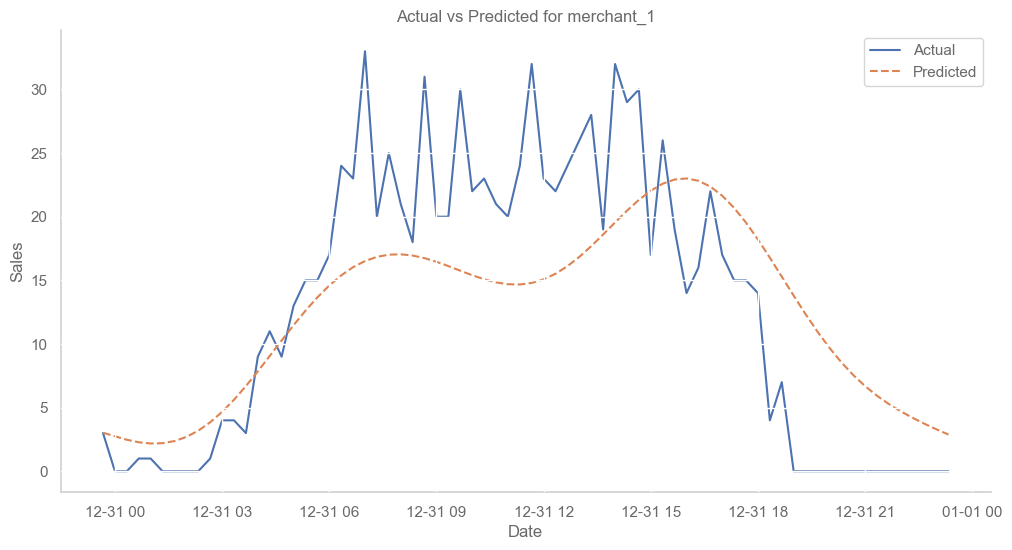

10:18:57 - cmdstanpy - INFO - Chain [1] start processing
10:18:58 - cmdstanpy - INFO - Chain [1] done processing


merchant_10 - RMSE: 7.98, MAE: 5.97


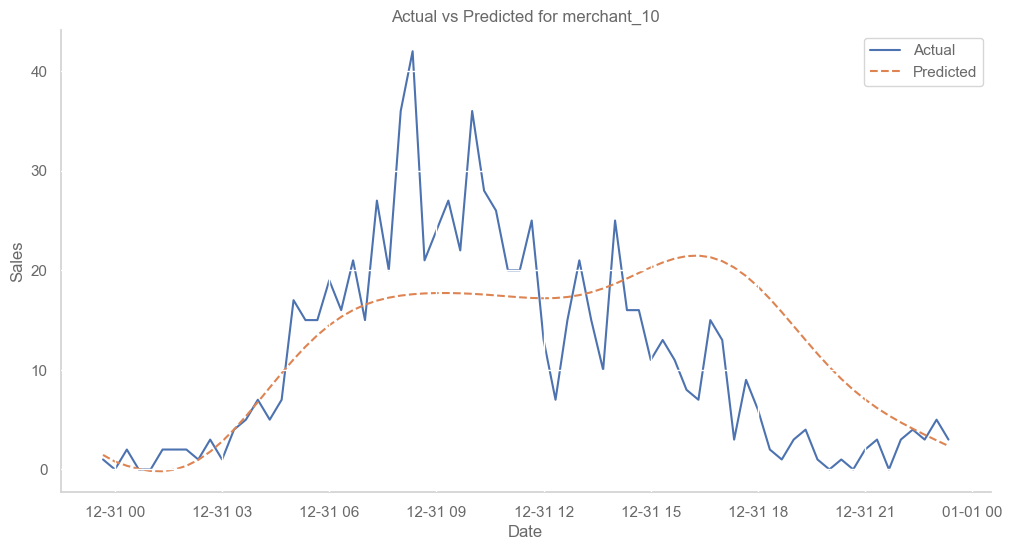

10:18:59 - cmdstanpy - INFO - Chain [1] start processing
10:18:59 - cmdstanpy - INFO - Chain [1] done processing


merchant_2 - RMSE: 5.38, MAE: 4.08


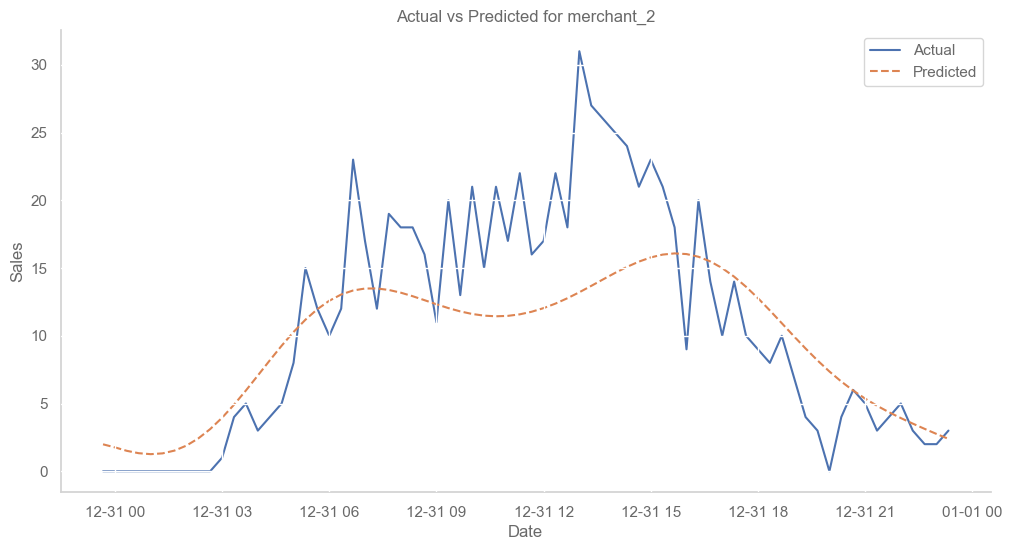

10:19:01 - cmdstanpy - INFO - Chain [1] start processing
10:19:01 - cmdstanpy - INFO - Chain [1] done processing


merchant_3 - RMSE: 3.93, MAE: 3.20


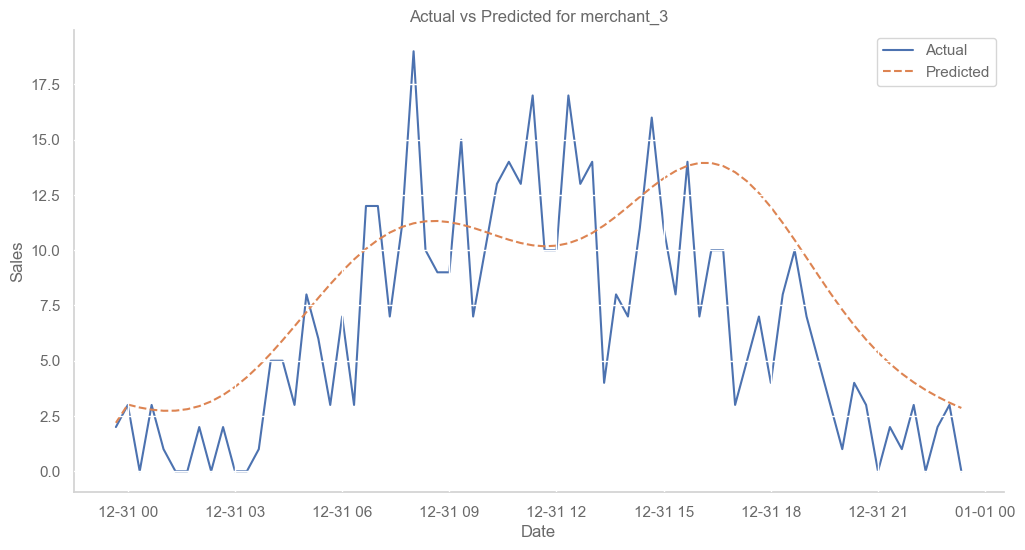

10:19:03 - cmdstanpy - INFO - Chain [1] start processing
10:19:03 - cmdstanpy - INFO - Chain [1] done processing


merchant_4 - RMSE: 6.60, MAE: 4.86


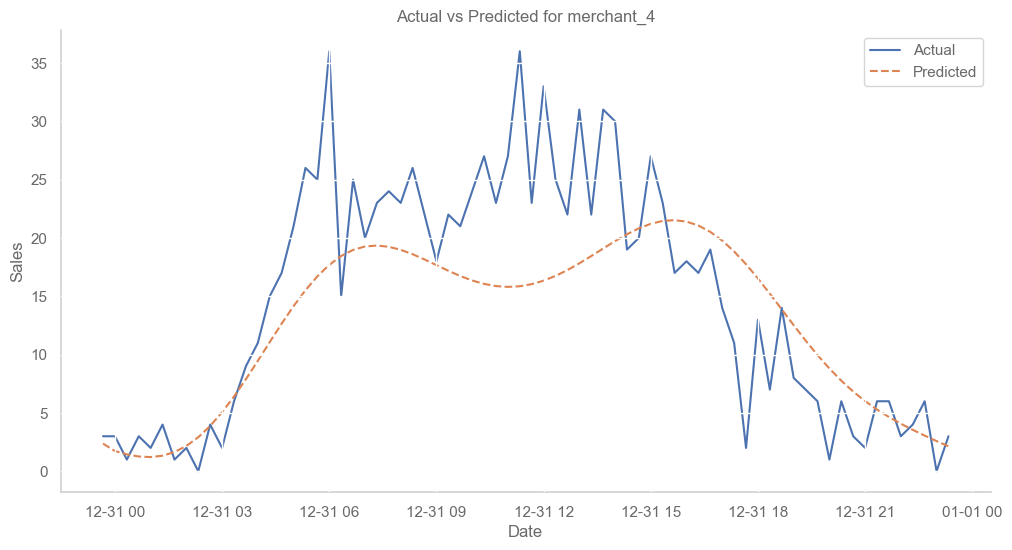

10:19:04 - cmdstanpy - INFO - Chain [1] start processing
10:19:04 - cmdstanpy - INFO - Chain [1] done processing


merchant_5 - RMSE: 6.91, MAE: 5.60


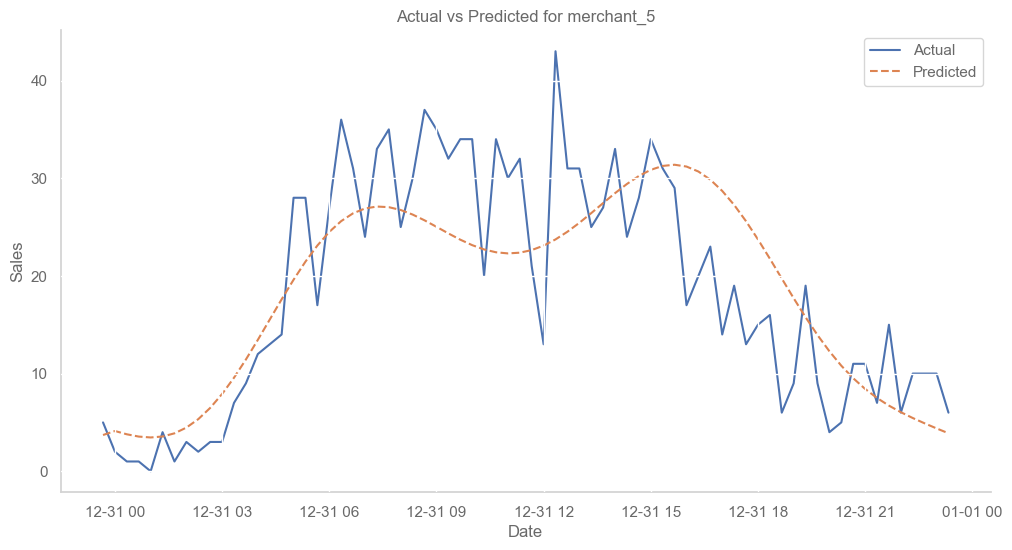

10:19:05 - cmdstanpy - INFO - Chain [1] start processing
10:19:06 - cmdstanpy - INFO - Chain [1] done processing


merchant_6 - RMSE: 3.91, MAE: 3.15


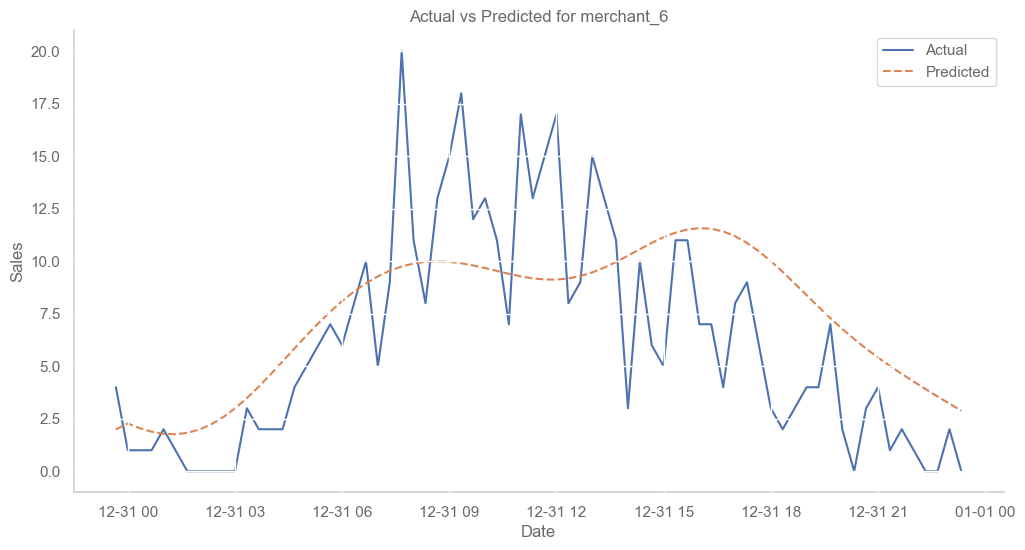

10:19:07 - cmdstanpy - INFO - Chain [1] start processing
10:19:07 - cmdstanpy - INFO - Chain [1] done processing


merchant_7 - RMSE: 4.04, MAE: 3.32


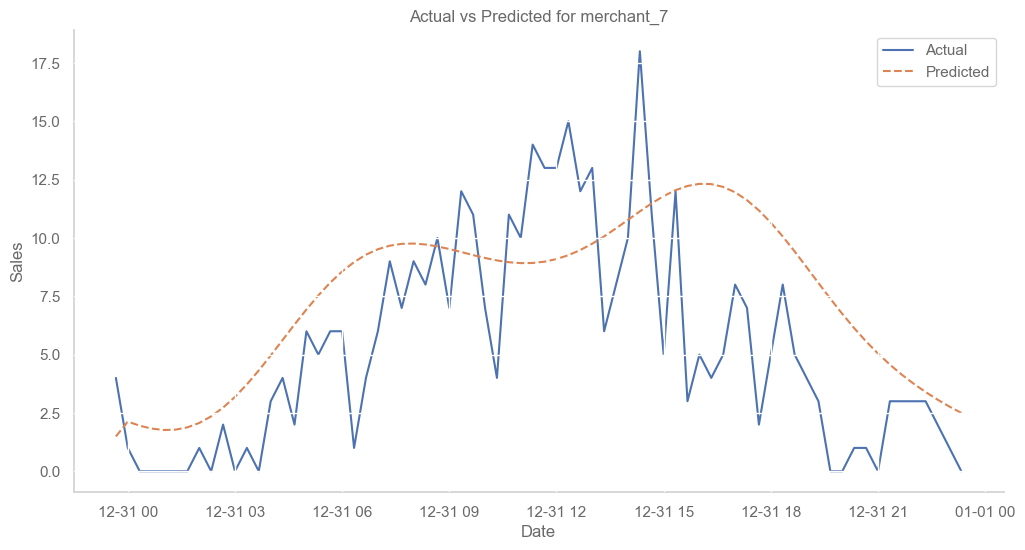

10:19:08 - cmdstanpy - INFO - Chain [1] start processing
10:19:08 - cmdstanpy - INFO - Chain [1] done processing


merchant_8 - RMSE: 10.89, MAE: 9.67


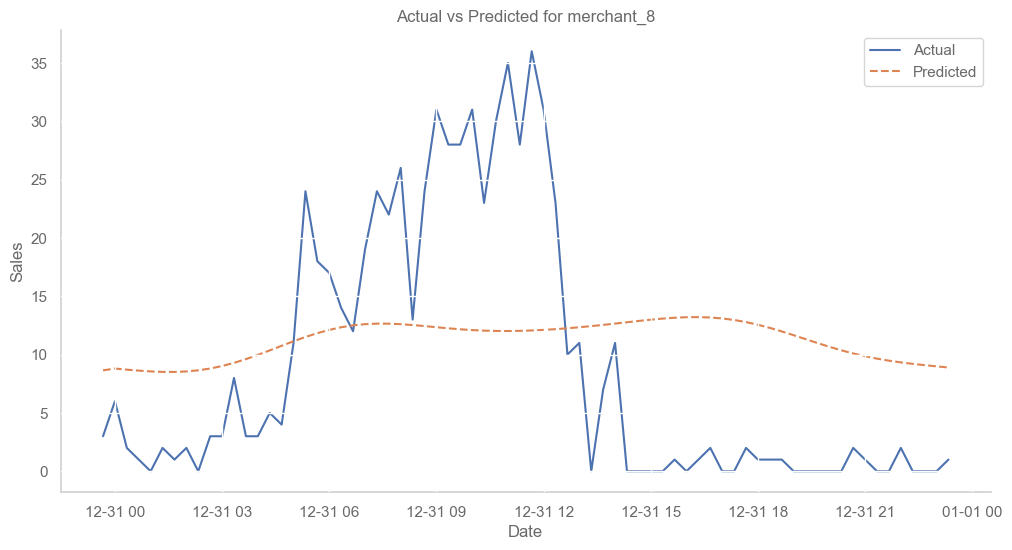

10:19:09 - cmdstanpy - INFO - Chain [1] start processing
10:19:09 - cmdstanpy - INFO - Chain [1] done processing


merchant_9 - RMSE: 5.59, MAE: 4.38


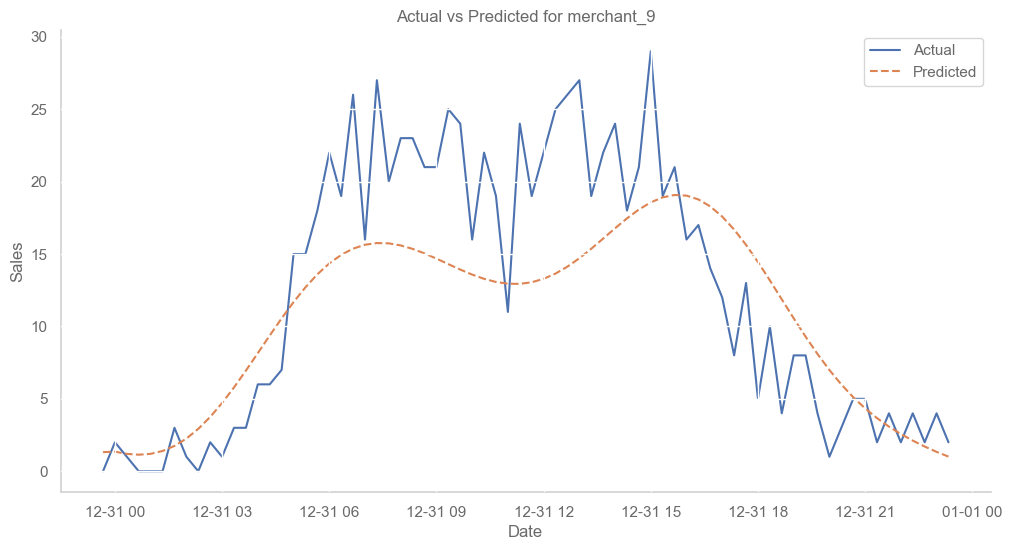

In [28]:
#PROPHET MODEL

forecasted_dfs = []

for feature in total_orders_df.columns:
    
    #formatting
    df_copy = total_orders_df[feature].copy().reset_index()
    df_copy.columns = ['ds','y']
    df_copy[['y']] = df_copy[['y']].apply(pd.to_numeric)

    df_copy['ds'] = pd.to_datetime(df_copy['ds'])
    
    df_copy_ = df_copy[df_copy['ds'] < forecast_start_date]
    
    #finding the right params_dict for this category
    params_dict = dicts[feature]
    
    #model
    m = Prophet(changepoint_prior_scale = dicts[feature]['changepoint_prior_scale'],
                seasonality_prior_scale = dicts[feature]['seasonality_prior_scale'],
                seasonality_mode = 'multiplicative',
                #changepoint_range= len(df_copy/365),
                holidays=holiday
                 )
    
    m.fit(df_copy_)

    future = m.make_future_dataframe(periods=prediction_days * 72, freq='20min')
    fcst_prophet_train = m.predict(future)
    
    filter = fcst_prophet_train['ds']>=forecast_start_date 
    predicted_df = fcst_prophet_train[filter][['ds','yhat']]
    predicted_df = predicted_df.merge(df_copy)

    #print(feature,mape(predicted_df['y'],predicted_df['yhat']))
    # Calculate RMSE and MAE
    rmse = np.sqrt(np.mean((predicted_df['y'] - predicted_df['yhat'])**2))
    mae = np.mean(np.abs(predicted_df['y'] - predicted_df['yhat']))

    print(f"{feature} - RMSE: {rmse:.2f}, MAE: {mae:.2f}")
    
    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(predicted_df['ds'], predicted_df['y'], label='Actual')
    plt.plot(predicted_df['ds'], predicted_df['yhat'], label='Predicted', linestyle='--')
    plt.title(f'Actual vs Predicted for {feature}')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(True)
    plt.show()

### FINAL FORECASTING